# MNIST Classification with Flux.jl

This tutorial demonstrates how to build, train, and evaluate a neural network to classify handwritten digits from the MNIST dataset using Julia's **Flux.jl** library. We'll use **MLDatasets.jl** to load the data and **Plots.jl** for visualization.

## Objectives
- Load and preprocess the MNIST dataset.
- Build a neural network with Flux.
- Train the model and track performance metrics.
- Visualize predictions and training progress.

## Prerequisites
- Julia 1.6+ installed.
- Install required packages: `Flux`, `MLDatasets`, `Plots`, `Random`.

Let's get started!

## Step 1: Setup and Imports

First, we import the necessary libraries and set up the plotting backend. We also create a directory to save our plots.

In [11]:
using Flux, MLDatasets, Plots, Random
gr()  # Use GR backend for Plots

# Create output directory for saving plots
mkpath("mnist")

"mnist"

## Step 2: Load and Preprocess MNIST Data

We load the MNIST dataset, which contains 60,000 training and 10,000 test images of handwritten digits (0-9). Each image is 28x28 pixels. We preprocess the data by:
- Flattening images into 784-dimensional vectors (28*28).
- Normalizing pixel values to [0,1].
- One-hot encoding the labels for training.

We also create a `DataLoader` for efficient batching during training.

In [12]:
# Load MNIST data
train_data = MLDatasets.MNIST(split=:train)
test_data = MLDatasets.MNIST(split=:test)

# Preprocess data
train_x = reshape(train_data.features, 28*28, :) ./ 255f0  # (784, 60000)
train_y = Flux.onehotbatch(train_data.targets, 0:9)        # (10, 60000)
test_x = reshape(test_data.features, 28*28, :) ./ 255f0   # (784, 10000)
test_y = test_data.targets                                 # (10000,)

# Create DataLoader for training
batch_size = 128
data = Flux.DataLoader((train_x, train_y), batchsize=batch_size, shuffle=true)

469-element DataLoader(::Tuple{Matrix{Float32}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}, shuffle=true, batchsize=128)
  with first element:
  (784×128 Matrix{Float32}, 10×128 OneHotMatrix(::Vector{UInt32}) with eltype Bool,)

## Step 3: Define the Neural Network

We define a simple feedforward neural network with three layers:
- Input layer: 784 neurons (flattened image).
- Two hidden layers: 256 and 128 neurons with ReLU activation.
- Output layer: 10 neurons (one for each digit).

The model will output logits, which we'll pass through a softmax function implicitly via the loss function.

In [13]:
model = Chain(
    Dense(784 => 256, relu),
    Dense(256 => 128, relu),
    Dense(128 => 10)
)

Chain(
  Dense(784 => 256, relu),              # 200_960 parameters
  Dense(256 => 128, relu),              # 32_896 parameters
  Dense(128 => 10),                     # 1_290 parameters
)                   # Total: 6 arrays, 235_146 parameters, 918.844 KiB.

## Step 4: Set Up Optimizer and Loss Function

We use the **ADAM** optimizer with a learning rate of 0.001. The loss function is **logit cross-entropy**, which combines softmax and cross-entropy for numerical stability.

In [14]:
# Define optimizer
opt = Flux.ADAM(0.001)
state = Flux.setup(opt, model)

# Define loss function
loss(model, x, y) = Flux.logitcrossentropy(model(x), y)

loss (generic function with 1 method)

## Step 5: Visualization Function

We define a function to visualize predictions on random test images. It displays 5 images with their predicted and true labels, saving the plot to the `mnist` directory.

In [15]:
function show_predictions(model, test_x, test_y, epoch)
    indices = randperm(size(test_x, 2))[1:5]  # Random unique indices
    plot_list = []
    for idx in indices
        img = reshape(test_x[:, idx], 28, 28)
        pred = Flux.onecold(model(test_x[:, idx]), 0:9)
        true_label = test_y[idx]
        p = heatmap(img, color=:grays, axis=false, title="P: $pred, T: $true_label", 
                    aspect_ratio=:equal, size=(200, 200), colorbar=false)
        push!(plot_list, p)
    end
    pred_plot = plot(plot_list..., layout=(1, 5), size=(800, 200))
    savefig(pred_plot, joinpath("mnist", "predictions_epoch_$epoch.png"))
    display(pred_plot)
end

show_predictions (generic function with 1 method)

## Step 6: Training Loop

We train the model for 3 epochs, tracking loss and accuracy. For each epoch:
- Train on mini-batches using `Flux.train!`.
- Compute the average loss, weighted by batch size.
- Evaluate accuracy on the test set using batched predictions.
- Plot and save accuracy/loss curves.
- Visualize predictions on random test images.

Epoch 1: Accuracy = 86.13%, Loss = 1.0181
Epoch 2: Accuracy = 89.71%, Loss = 0.4078
Epoch 3: Accuracy = 90.84%, Loss = 0.3382


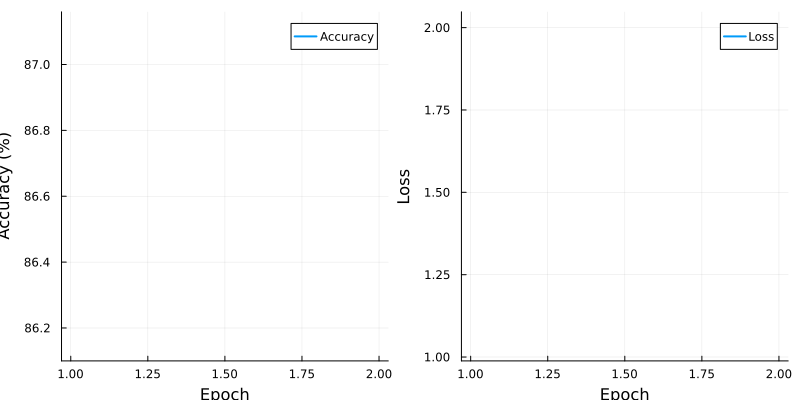

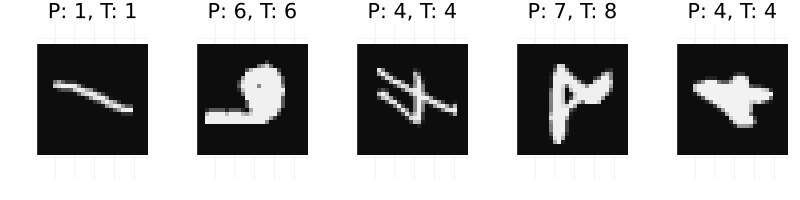

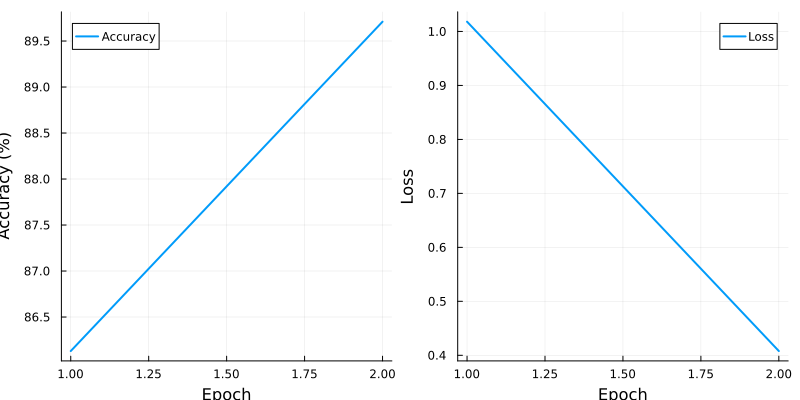

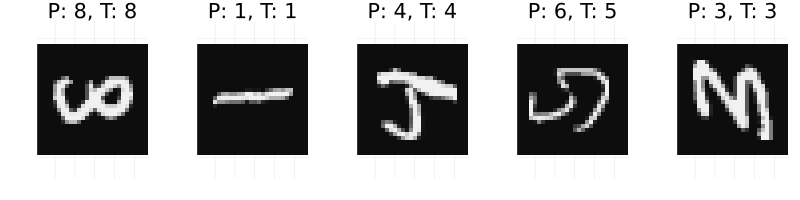

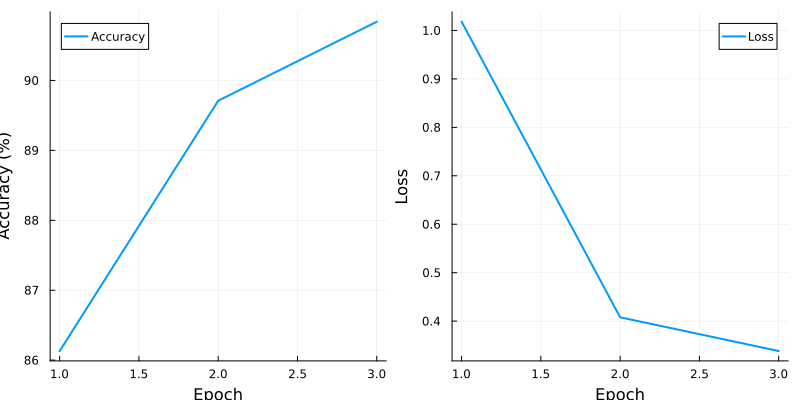

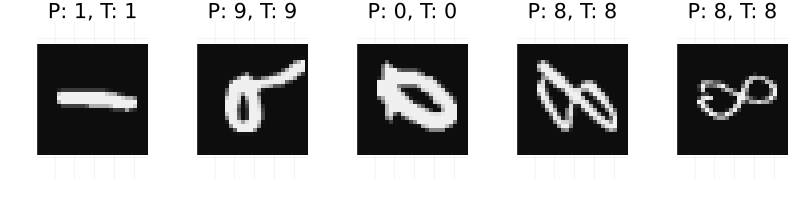

In [16]:
# Initialize arrays to track metrics
accuracies = Float32[]
losses = Float32[]

# Training loop
for epoch in 1:3
    # Train and compute loss
    epoch_loss = 0.0
    total_samples = 0
    for (x, y) in data
        Flux.train!(loss, model, [(x, y)], state)
        batch_loss = loss(model, x, y)
        epoch_loss += batch_loss * size(x, 2)
        total_samples += size(x, 2)
    end
    avg_loss = epoch_loss / total_samples
    push!(losses, avg_loss)
    
    # Compute test accuracy
    test_loader = Flux.DataLoader((test_x, test_y), batchsize=batch_size, shuffle=false)
    correct = 0
    total = 0
    for (x, y) in test_loader
        preds = Flux.onecold(model(x), 0:9)
        correct += sum(preds .== y)
        total += length(y)
    end
    accuracy = correct / total
    push!(accuracies, accuracy)
    
    # Print metrics
    println("Epoch $epoch: Accuracy = $(round(accuracy*100, digits=2))%, Loss = $(round(avg_loss, digits=4))")
    
    # Plot accuracy and loss
    p1 = plot(1:epoch, accuracies * 100, label="Accuracy", xlabel="Epoch", ylabel="Accuracy (%)", lw=2)
    p2 = plot(1:epoch, losses, label="Loss", xlabel="Epoch", ylabel="Loss", lw=2)
    metrics_plot = plot(p1, p2, layout=(1, 2), size=(800, 400))
    savefig(metrics_plot, joinpath("mnist", "metrics_epoch_$epoch.png"))
    display(metrics_plot)
    
    # Show predictions
    show_predictions(model, test_x, test_y, epoch)
end

## Step 7: Results

After 3 epochs, you should see:
- **Accuracy**: ~95-98% on the test set.
- **Loss**: Decreasing steadily (e.g., from ~0.3 to ~0.1).
- **Plots**:
  - `metrics_epoch_$epoch.png`: Accuracy and loss curves.
  - `predictions_epoch_$epoch.png`: 5 test images with predicted/true labels.

## Next Steps
- Increase the number of epochs (e.g., 10) for better accuracy.
- Experiment with model architecture (e.g., add dropout layers).
- Use GPU acceleration with `Flux.gpu` (requires CUDA).
- Add early stopping based on validation loss.

Happy learning with Julia and Flux!

### Task 4: Evaluate Model Performance

**Objective**: Compute a confusion matrix to analyze the model's test set predictions.

**Instructions**:
- A confusion matrix shows how often each true label is predicted as each possible label.
- Create a 10x10 matrix (for digits 0-9) where `conf_matrix[i,j]` is the number of times true label `i-1` was predicted as `j-1`.
- Use the test set predictions after training.
- Hint: Loop over the `test_loader`, compare true labels (`y`) with predictions (`Flux.onecold(model(x), 0:9)`), and increment matrix entries.
- Display the matrix using `println` or `display`.

**Why?**: Confusion matrices reveal which digits the model confuses (e.g., 7 vs. 1).

In [17]:
# Task 4: Compute confusion matrix
conf_matrix = zeros(Int, 10, 10) # 10x10 matrix for digits 0-9

# Your code here

# Display the confusion matrix
println("Confusion Matrix (rows: true, cols: predicted):")
display(conf_matrix)

10×10 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0

Confusion Matrix (rows: true, cols: predicted):


In [18]:
# Task 4: Compute confusion matrix
conf_matrix = zeros(Int, 10, 10) # 10x10 matrix for digits 0-9

# Loop over test data in batches
test_loader = Flux.DataLoader((test_x, test_y), batchsize=batch_size, shuffle=false)
for (x, y) in test_loader
    preds = Flux.onecold(model(x), 0:9) # Get predicted labels (0-9)
    for i in 1:length(y)
        true_label = y[i] # True label (0-9)
        pred_label = preds[i] # Predicted label (0-9)
        conf_matrix[true_label+1, pred_label+1] += 1 # Increment matrix
    end
end

# Display the confusion matrix
println("Confusion Matrix (rows: true, cols: predicted):")
display(conf_matrix)

Confusion Matrix (rows: true, cols: predicted):


10×10 Matrix{Int64}:
 956     0    6    2    1    7    4    2    2    0
   0  1110    8    2    0    2    3    1    9    0
  13     7  951    8    8    2   15    7   19    2
   3     2   33  912    0   34    0   11   12    3
   1     6   11    1  894    1   15    1    9   43
  15     3    7   64    6  750   14    7   23    3
  19     4   17    0    7   17  893    0    1    0
   5    17   41    7    4    0    0  926    1   27
   7    10   20   38   11   40   15    4  822    7
  16     9    2   18   47    9    0   30    8  870